In [41]:
import torch
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [42]:
image_path = Path("/kaggle/input/gender-detection/data")
gender_train_dir = image_path / "train"
gender_val_dir = image_path / "test"
shape_base = Path("/kaggle/input/face-shape-dataset/FaceShape Dataset")
shape_train_dir = shape_base/"train"
shape_val_dir = shape_base /"test"

In [43]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))

def get_transforms():
 return transforms.Compose([
 transforms.Resize((224, 224)),
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ])

batch_size = 32
gender_train_ds = datasets.ImageFolder(root=gender_train_dir, loader=safe_pil_loader, transform=get_transforms())
gender_val_ds = datasets.ImageFolder(root=gender_val_dir, loader=safe_pil_loader, transform=get_transforms())
shape_train_ds = datasets.ImageFolder(root=shape_train_dir, loader=safe_pil_loader, transform=get_transforms())
shape_val_ds = datasets.ImageFolder(root=shape_val_dir, loader=safe_pil_loader, transform=get_transforms())

gender_train_loader = DataLoader(gender_train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
gender_val_loader = DataLoader(gender_val_ds, batch_size=batch_size, pin_memory=True)
shape_train_loader = DataLoader(shape_train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
shape_val_loader = DataLoader(shape_val_ds, batch_size=batch_size, pin_memory=True)


In [44]:
class MultiTaskModel(nn.Module):
    def __init__(self, backbone_name="resnet18", num_shape_classes=5):
        super().__init__()
        backbone = getattr(models, backbone_name)(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        feat_dim = backbone.fc.in_features
        self.gender_head = nn.Linear(feat_dim, 2)
        self.shape_head = nn.Linear(feat_dim, num_shape_classes)

    def forward(self, x):
        x = self.features(x).view(x.size(0), -1)
        return self.gender_head(x), self.shape_head(x)

In [45]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = MultiTaskModel()
if use_cuda and torch.cuda.device_count() > 1:
 model = nn.DataParallel(model)
 print(f"Using.... {torch.cuda.device_count()} GPU")
model = model.to(device)


Using.... 2 GPU


In [46]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

optim = optim.Adam(model.parameters(), lr=1e-4)
crit_gender = nn.CrossEntropyLoss()
crit_shape  = nn.CrossEntropyLoss()

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []
test_losses  = []
test_accs    = []

def train_epoch():
    model.train()
    total_train_loss = total_train_correct = total_train_samples = 0

    running_loss = running_correct = running_total_samples = 0
    for batch_idx, (imgs, labels) in enumerate(gender_train_loader, 1):
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optim.zero_grad()
        g_logits, _ = model(imgs)
        loss = crit_gender(g_logits, labels)
        loss.backward()
        optim.step()

        preds = g_logits.argmax(1)
        running_loss += loss.item()
        running_correct += (preds == labels).sum().item()
        running_total_samples += labels.size(0)

        total_train_loss += loss.item()
        total_train_correct += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

        if batch_idx % 100 == 0:
            avg_loss = running_loss / 100
            avg_acc  = running_correct / running_total_samples
            print(f"[Gender Train] Batch {batch_idx}, Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
            running_loss = running_correct = running_total_samples = 0

    running_loss = running_correct = running_total_samples = 0
    for batch_idx, (imgs, labels) in enumerate(shape_train_loader, 1):
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optim.zero_grad()
        _, s_logits = model(imgs)
        loss = crit_shape(s_logits, labels)
        loss.backward()
        optim.step()

        preds = s_logits.argmax(1)
        running_loss += loss.item()
        running_correct += (preds == labels).sum().item()
        running_total_samples += labels.size(0)

        total_train_loss += loss.item()
        total_train_correct += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

        if batch_idx % 100 == 0:
            avg_loss = running_loss / 100
            avg_acc  = running_correct / running_total_samples
            print(f"[Shape Train] Batch {batch_idx}, Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
            running_loss = running_correct = running_total_samples = 0

    epoch_loss = total_train_loss / (len(gender_train_loader) + len(shape_train_loader))
    epoch_acc = total_train_correct / total_train_samples
    return epoch_loss, epoch_acc

def eval_epoch():
    model.eval()
    total_g = correct_g = 0
    total_s = correct_s = 0
    loss_g = loss_s = 0.0

    with torch.no_grad():
        for imgs, labels in gender_val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            g_logits, _ = model(imgs)
            loss_g += crit_gender(g_logits, labels).item()
            preds = g_logits.argmax(1)
            total_g += labels.size(0)
            correct_g += (preds == labels).sum().item()

        for imgs, labels in shape_val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            _, s_logits = model(imgs)
            loss_s += crit_shape(s_logits, labels).item()
            preds = s_logits.argmax(1)
            total_s += labels.size(0)
            correct_s += (preds == labels).sum().item()

    avg_loss = (loss_g/len(gender_val_loader) + loss_s/len(shape_val_loader)) / 2
    avg_acc  = (correct_g/total_g + correct_s/total_s) / 2
    print(f"[Val] Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
    return avg_loss, avg_acc


In [47]:
gender_classes = gender_train_ds.classes
shape_classes  = shape_train_ds.classes
def predict(image_path: str):
    img = save_pil_loader(image_path)
    inp = get_transforms()(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        g_logits, s_logits = model(inp)
        return gender_classes[g_logits.argmax(1).item()], shape_classes[s_logits.argmax(1).item()]

In [48]:
import random
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt

def test_random_images(test_dataloader, model, device,
                       class_names_gender, class_names_shape,
                       mean, std, num_samples=10):
    model.eval()
    batch = next(iter(test_dataloader))

    if isinstance(batch, (list, tuple)) and len(batch) == 2:
        images, labels = batch
    else:
        images = batch
        labels = None

    indices = random.sample(range(len(images)), min(num_samples, len(images)))
    images = images[indices]
    
    if labels is not None:
        labels = labels[indices]

    resize = transforms.Resize((224, 224))
    images = torch.stack([resize(img) for img in images])

    images = images.to(device, non_blocking=True)
    with torch.no_grad():
        g_logits, s_logits = model(images)
        g_preds = g_logits.argmax(dim=1).cpu()
        s_preds = s_logits.argmax(dim=1).cpu()

    images = images.cpu()
    
    inv_norm = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )

    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        img_disp = inv_norm(img)
        img_disp = torch.clamp(img_disp, 0.0, 1.0)
        np_img = img_disp.permute(1, 2, 0).numpy()

        plt.imshow(np_img)
        gender_name = class_names_gender[g_preds[i].item()]
        shape_name = class_names_shape[s_preds[i].item()]
        plt.title(f"Gender: {gender_name}\nShape: {shape_name}", fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    results = []
    for i in range(len(images)):
        true = None
        if labels is not None:
            true = labels[i].item()
        results.append({
            'gender_pred': class_names_gender[g_preds[i].item()],
            'shape_pred': class_names_shape[s_preds[i].item()],
            'true_label': true
        })
    return results

Using.... 2 GPU
Epoch 1/5
[Gender Train] Batch 100, Loss: 0.2116, Acc: 0.9119
[Gender Train] Batch 200, Loss: 0.1227, Acc: 0.9519
[Gender Train] Batch 300, Loss: 0.1187, Acc: 0.9575
[Shape Train] Batch 100, Loss: 1.3183, Acc: 0.4447
[Shape Train] Batch 200, Loss: 0.8908, Acc: 0.6603
[Shape Train] Batch 300, Loss: 0.6831, Acc: 0.7525
[Shape Train] Batch 400, Loss: 0.5093, Acc: 0.8165
[Val] Loss: 0.5345, Acc: 0.7865
Epoch 2/5
[Gender Train] Batch 100, Loss: 0.0704, Acc: 0.9744
[Gender Train] Batch 200, Loss: 0.0650, Acc: 0.9781
[Gender Train] Batch 300, Loss: 0.0514, Acc: 0.9847
[Shape Train] Batch 100, Loss: 0.3265, Acc: 0.8875
[Shape Train] Batch 200, Loss: 0.2740, Acc: 0.9006
[Shape Train] Batch 300, Loss: 0.2575, Acc: 0.9106
[Shape Train] Batch 400, Loss: 0.2504, Acc: 0.9105
[Val] Loss: 0.4474, Acc: 0.8426
Epoch 3/5
[Gender Train] Batch 100, Loss: 0.0470, Acc: 0.9859
[Gender Train] Batch 200, Loss: 0.0424, Acc: 0.9859
[Gender Train] Batch 300, Loss: 0.0437, Acc: 0.9847
[Shape Train] 

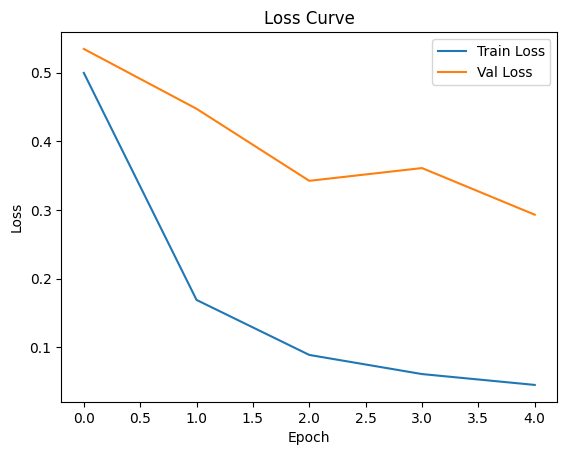

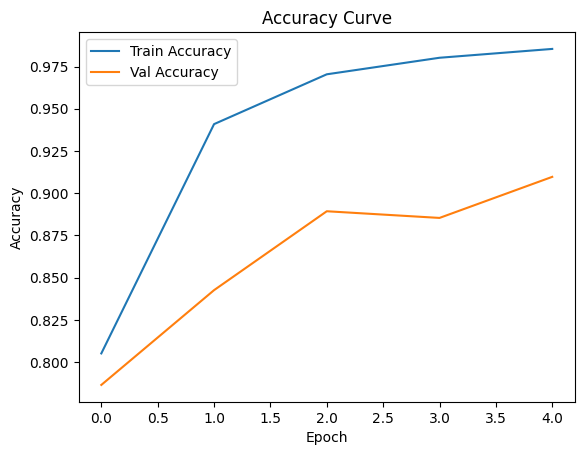

In [49]:
if __name__ == "__main__":
    epochs = 5
    print(f"Using.... {torch.cuda.device_count()} GPU")
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch()
        val_loss, val_acc = eval_epoch()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.show()

In [50]:
save_path = "mtl_model_1.pth"
state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
torch.save(state_dict, save_path)
print(f"Model saved to {save_path}")

Model saved to mtl_model_1.pth


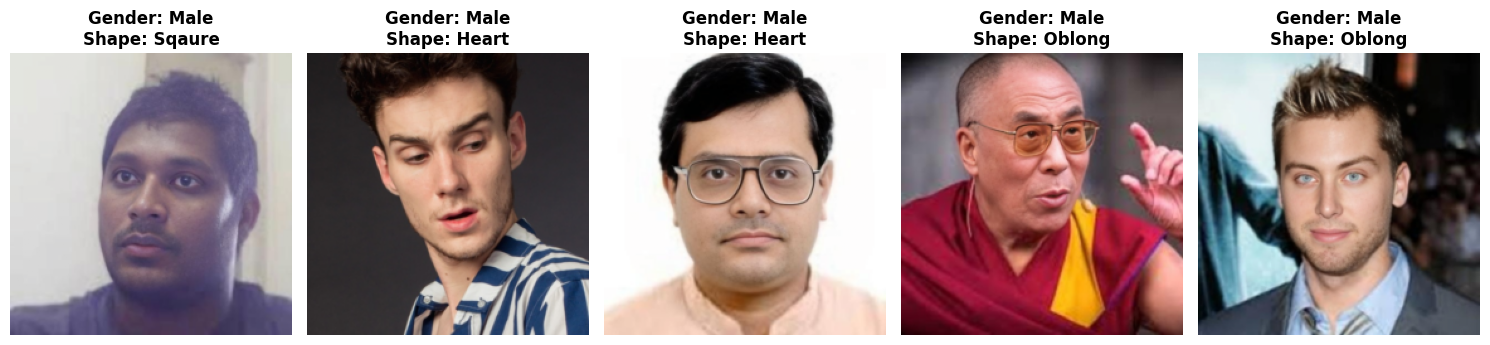

In [54]:
gender_classes = ['Male', 'Female']
shape_classes = ['Heart', 'Oblong', 'Oval', 'Round', 'Sqaure'] 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
results = test_random_images(gender_val_loader, model, device,
     gender_classes, shape_classes, mean, std, num_samples=5)